In [1]:
!pip install keras==2.2.4
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14
!pip install numpy=1.16.1

     |████████████████████████████████| 312 kB 8.2 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.4 which is incompatible.
     |████████████████████████████████| 109.3 MB 46 kB/s 
     |████████████████████████████████| 3.1 MB 32.7 MB/s 
     |████████████████████████████████| 488 kB 49.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Unins

In [2]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'2.2.4'

In [3]:
!wget https://github.com/rickiepark/deep-learning-with-python-notebooks/archive/master.zip
!unzip master.zip
!mv deep-learning-with-python-notebooks-master/datasets ./

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9115_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9116_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9117_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9118_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9119_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/911_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9120_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9121_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsup/9122_0.txt  
  inflating: deep-learning-with-python-notebooks-master/datasets/aclImdb/train/unsu

### 사전 학습된 특성 추출 & 미세 조정

<br/>

**특성 추출** : 사전 학습된 네트워크의 representation을 활용하여 새로운 지도학습용 샘플로부터 주어진 태스크를 해결하는데 유용한 특성을 추출, 학습. 모델의 합성곱 기반층(convolutional base)를 Feature extractor 또는 backbone이라고 명명함

합성곱 층만 재사용하는 것이 권장됨. **합성곱 층에 의해 학습된 표현이 보다 일반적인 특성**(에지, 질감, 색 등)을 가지고 있기 때문에 다른 태스크에도 재사용이 가능 

완전 연결 분류기의 재사용이 권장되지 않는 이유는 **분류기에 가까운 층은 task specific한 특성을 학습함**. 훈련된 클래스 집합에 특화된 표현을 학습(고양이, 개 등). 특히 분류기인 완전 연결 층은 Flatten 연산을 사용하기 때문에 합성곱 계층과 달리 이미지의 객체 및 공간 정보를 상실함.

모델의 하위 층(입력에 가까운)은 지역적이고 매우 일반적인 feature map 학습, 상위 층(출력에 가까운 층)은 강아지 눈, 고양이 코 같이 보다 추상적이고, 태스크의 클래스 집합에 특화된 표현을 학습.

사전 학습된 모델을 보다 일반적인 케이스들에 적용하고 싶으면 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋음.

In [18]:
# ImageNet 데이터셋으로 사전 학습된 VGG16 네트워크
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,  # 완전 연결 분류기 포함 X
                  input_shape=(150, 150, 3))

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

최종 feature map은 (4, 4, 512) 사이즈

conv_base 위에 완전 연결층(분류기)를 쌓아 최종 모델 구축

In [6]:
import os, shutil

In [7]:
# 원본 데이터 경로
original_dataset_dir = '/content/datasets/cats_and_dogs/train'

# 저장 경로
base_dir = '/content/datasets/cats_and_dogs/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 이미 디렉토리가 존재하면 삭제하고 새로 만듬.
    shutil.rmtree(base_dir)  
os.mkdir(base_dir)

# 학습, 검증, 테스트 데이터 경로 설정
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/datasets/cats_and_dogs/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
def extract_features(directory, sample_count):  # 경로, 배치 사이즈
    
    # 할당용
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    # 주어진 경로로부터 학습 데이터를 불러오는 generator
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        # (batch, 150, 150, 3)크기 입력을 전달해서 (batch, 4, 4, 512) 4D Tensor(feature map) 출력
        features_batch = conv_base.predict(inputs_batch)  
        
        # 반복문 1회에 0~19 인덱스, 2회차에 20~39 인덱스, 3회차에 40~59 인덱스, ...
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면(i=2000) 중지
            break
            
    return features, labels

In [16]:
# 사전 학습된 VGG16의 파라미터를 사용하여 주어진 입력으로부터 특성을 추출
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 특성 추출 함수 보충

In [13]:
generator[0][0].shape  # 한 번에 (150, 150, 3) 사이즈의 이미지를 20개 불러옴 (inputs_batch)

(20, 150, 150, 3)

In [14]:
generator[0][1]  # 20개 이미지에 해당하는 라벨 20개 (labels_batch)

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0.], dtype=float32)

In [15]:
i=0
for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    if i==0:
        break

print(features_batch)
print(features_batch.shape)

[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.19647038e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.91783571e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.75499046e-01 ... 0.00000000e+00
    6.70046031e-01 0.00000000e+00]
   [1.70559883e-01 0.00000000e+00 1.29372120e+00 ... 1.29492655e-01
    1.94750220e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.31746781e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.14615047e-01 ... 0.00000000e+00
    2.68612862e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 8.35601628e-01 ... 4.97467890e-02
    7.49470532e-01 0.00000000e+00]
   [2.02129707e-01 0.00000000e+00 2.38842154e+00 ... 3.03056538e-01
    5.64234078e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 2.56151557e-02 ... 0.00000000e+00
    1.81434631e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.70476556e-01 ... 0.00000000e+00
 

In [21]:
# 추출된 특성의 크기는 (samples, 4, 4, 512). 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 flatten
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [22]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# 사전 학습된 VGG16의 출력인 feature map(4 x 4 x 512)을 입력으로 사용
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 760us/step - loss: 0.6060 - acc: 0.6530 - val_loss: 0.4566 - val_acc: 0.8120
Epoch 2/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.4277 - acc: 0.8125 - val_loss: 0.3712 - val_acc: 0.8560
Epoch 3/30
2000/2000 [==============================] - 1s 286us/step - loss: 0.3614 - acc: 0.8490 - val_loss: 0.3294 - val_acc: 0.8690
Epoch 4/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.3207 - acc: 0.8645 - val_loss: 0.3021 - val_acc: 0.8900
Epoch 5/30
2000/2000 [==============================] - 1s 277us/step - loss: 0.2925 - acc: 0.8785 - val_loss: 0.2860 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 1s 285us/step - loss: 0.2598 - acc: 0.8930 - val_loss: 0.2748 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.2499 - acc: 0.8985 - val_loss: 0.2676 - val_acc: 0.8970


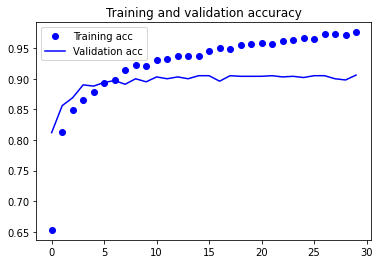

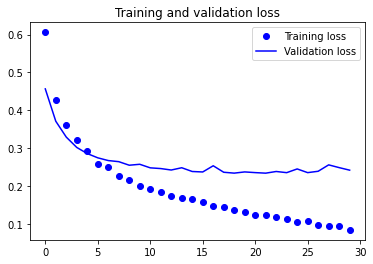

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
from keras import models
from keras import layers

# conv base(VGG16) + 완전 연결 분류기
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


사전 학습된 VGG16의 파라미터는 14714688개, 사전 학습 모델 위에 추가된 완전 연결 분류기의 파라미터는 1097408개.

모델을 컴파일하고 훈련하기 전에 사전 학습된 모델의 합성곱 레이어들을 동결하는 것이 중요. (사전 학습된 feature, representation을 그대로 사용하는 것이 목적)


In [26]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [27]:
# 추가한 2개의 dense layer의 파라미터만 훈련됨
conv_base.trainable = False

# 추가된 2개의 layer마다 가중치 행렬, 편향 벡터 총 4개의 텐서가 훈련됨
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [28]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 21s - loss: 0.5348 - acc: 0.7445 - val_loss: 0.4102 - val_acc: 0.8450
Epoch 2/30
 - 19s - loss: 0.3985 - acc: 0.8340 - val_loss: 0.3355 - val_acc: 0.8740
Epoch 3/30
 - 19s - loss: 0.3486 - acc: 0.8560 - val_loss: 0.3014 - val_acc: 0.8810
Epoch 4/30
 - 21s - loss: 0.3210 - acc: 0.8695 - val_loss: 0.2822 - val_acc: 0.8870
Epoch 5/30
 - 19s - loss: 0.3045 - acc: 0.8700 - val_loss: 0.2712 - val_acc: 0.8860
Epoch 6/30
 - 19s - loss: 0.2884 - acc: 0.8840 - val_loss: 0.2641 - val_acc: 0.8970
Epoch 7/30
 - 18s - loss: 0.2706 - acc: 0.8895 - val_loss: 0.2560 - val_acc: 0.8940
Epoch 8/30
 - 19s - loss: 0.2686 - acc: 0.8900 - val_loss: 0.2574 - val_acc: 0.8930
Epoch 9/30
 - 19s - loss: 0.2648 - acc: 0.8920 - val_loss: 0.2550 - val_acc: 0.8920
Epoch 10/30
 - 19s - loss: 0.2498 - acc: 0.9025 - val_loss: 0.2459 - val_acc: 0.9010
Epoch 11/30
 - 19s - loss: 0.2421 - acc: 0.8995 - val_loss: 0.2486 - val_ac

In [29]:
model.save('cats_and_dogs_small_3.h5')

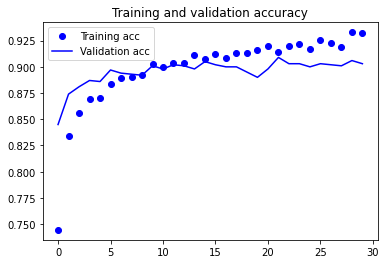

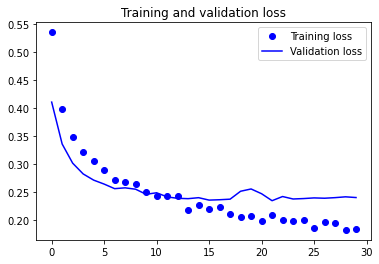

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 미세 조정

Fine-tuning : 특성 추출에 사용했던 사전 학습된 동결 모델의 상위 층 몇 개를 동결에서 해제하고, 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련.

주어진 문제에 조금 더 밀접하게 사전 학습된 모델의 표현을 일부 조정하는 효과. (task specific)

기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시켜 성능을 향상 (사전 학습 특성 추출 방식 보완)

1. 기반 네트워크에서 일부 층의 동결을 해제
2. 동결을 해제한 층과 새로 추가한 층을 함께 훈련

In [31]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

사전 학습된 VGG 네트워크의 마지막 층 3개 (block5_conv1, block5_conv2, block5_conv3)를 동결 해제.

미세 조정시에는 사전 학습된 네트워크의 최상위 2-3개 층만 미세 조정하는 것이 권장됨.
  - 하위 층(입력에 가까운 층)은 좀 더 일반적이고 다른 태스크에도 재사용이 가능한 특성들을 학습
  - 상위 층(출력에 가까운 층)일 수록 task specific
  -  새로운 태스크에 적용이 가능하도록 task specific한 특성, 표현들을 미세 조정하는 것이 효과적
  - 특히 학습 데이터셋이 작을 수록 많은 파라미터를 훈련시키도록(동결을 더 많이 해제) 하는 것은 과대적합의 위험이 있음

In [32]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 221ms/step - loss: 0.1632 - acc: 0.9370 - val_loss: 0.2158 - val_acc: 0.9200
Epoch 2/100
100/100 [==============================] - 20s 198ms/step - loss: 0.1701 - acc: 0.9320 - val_loss: 0.2207 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 20s 196ms/step - loss: 0.1205 - acc: 0.9510 - val_loss: 0.2445 - val_acc: 0.9100
Epoch 4/100
100/100 [==============================] - 20s 196ms/step - loss: 0.1278 - acc: 0.9485 - val_loss: 0.2066 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 20s 197ms/step - loss: 0.1166 - acc: 0.9530 - val_loss: 0.2095 - val_acc: 0.9250
Epoch 6/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0998 - acc: 0.9595 - val_loss: 0.2781 - val_acc: 0.9020
Epoch 7/100
100/100 [==============================] - 20s 196ms/step - loss: 0.0833 - acc: 0.9715 - val_loss: 0.2654 - val_acc: 0.9090
Epoch 8/100
100/100 [===========================

In [34]:
model.save('cats_and_dogs_small_4.h5')

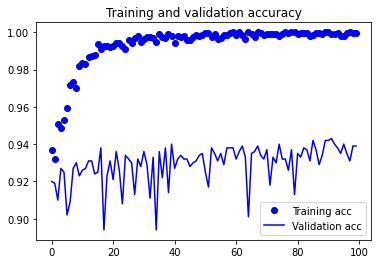

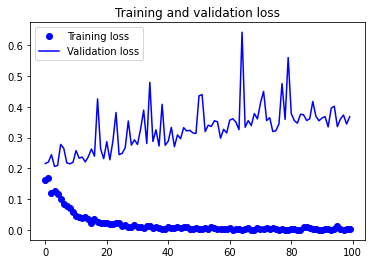

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

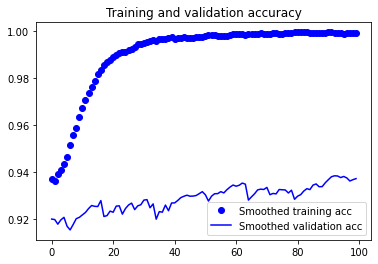

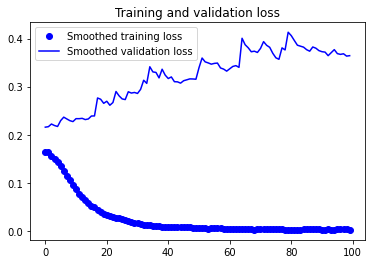

In [37]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
# 평가
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.938999993801117
